# Example: The retinal model system

In this tutorial, we demonstrate how to load and analyze surface hopping trajectory data for a retinal model system. 

Our goal is to illustrate a full workflow: importing trajectories, performing essential post-processing, and extracting three key reaction coordinates, which have been identified to comprehensively describe the photoinduced $S_0\rightarrow~S_1$ relaxation and the *cis/trans*-isomerization around the carbon-carbon double bond:

- a **torsion angle** around the central carbon-carbon double bond ($\varphi_{\text{C-C=C-C}}$),
- the **bond-length alternation (BLA)** of the full chromophore, and
- the **out-of-plane movement of the hydrogens (HOOP)** that are connected to the isomerizing C=C bond.

By the end of this guide, you will be able to compute these features from trajectory data and use them for mechanistic interpretation or downstream machine-learning applications.



In [1]:
import shnitsel as st
import shnitsel.xarray

## 1) Import and preparation of data
### 1.1) Loading data

In [2]:
dt = st.io.read('tut_data/traj_I02.nc', kind='shnitsel')
dt

<xarray.DataTree 'ROOT'>
Group: /
│   Attributes:
│       DataTree_Level:  ShnitselDBRoot
└── Group: /I02
    │   Attributes:
    │       DataTree_Level:  CompoundGroup
    │       compound_info:   {'compound_name': 'I02'}
    ├── Group: /I02/0
    │       Dimensions:              (time: 384, state: 3, atom: 14, direction: 3,
    │                                 statecomb: 3, full_statecomb: 6)
    │       Coordinates: (12/15)
    │         * time                 (time) float64 3kB 0.0 0.5 1.0 ... 190.5 191.0 191.5
    │         * state                (state) int64 24B 1 2 3
    │         * atom                 (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
    │         * direction            (direction) <U1 12B 'x' 'y' 'z'
    │         * statecomb            (statecomb) object 24B MultiIndex
    │         * full_statecomb       (full_statecomb) object 48B MultiIndex
    │           ...                   ...
    │           atNames              (atom) <U1 56B ...
    │           atNums               (atom) int64 112B ...
    │         * from                 (statecomb) int64 24B 1 1 2
    │         * to                   (statecomb) int64 24B 2 3 3
    │         * full_statecomb_from  (full_statecomb) int64 48B 1 1 2 2 3 3
    │         * full_statecomb_to    (full_statecomb) int64 48B 2 3 1 3 1 2
    │       Data variables:
    │           energy               (time, state) float32 5kB ...
    │           forces               (time, state, atom, direction) float32 194kB ...
    │           atXYZ                (time, atom, direction) float32 65kB ...
    │           dip_perm             (time, state, direction) float32 14kB ...
    │           dip_trans            (time, statecomb, direction) float32 14kB ...
    │           socs                 (time, full_statecomb) complex128 37kB ...
    │           astate               (time) int32 2kB ...
    │           sdiag                (time) int32 2kB ...
    │           phases               (time, state) float32 5kB ...
    │       Attributes: (12/15)
    │           input_format:           sharc
    │           t_max:                  1000.0
    │           delta_t:                0.5
    │           max_ts:                 384
    │           completed:              False
    │           input_type:             dynamic
    │           ...                     ...
    │           num_triplets:           0
    │           has_forces:             True
    │           misc_input_settings:    {'input': {'printlevel': '2', 'geomfile': '"geom"...
    │           trajectory_input_path:  retinal_tutorial/I02/TRAJ_00001
    │           trajid:                 1
    │           DataTree_Level:         TrajectoryData
    ├── Group: /I02/1
    │       Dimensions:              (time: 367, state: 3, atom: 14, direction: 3,
    │                                 statecomb: 3, full_statecomb: 6)
    │       Coordinates: (12/15)
    │         * time                 (time) float64 3kB 0.0 0.5 1.0 ... 182.0 182.5 183.0
    │         * state                (state) int64 24B 1 2 3
    │         * atom                 (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
    │         * direction            (direction) <U1 12B 'x' 'y' 'z'
    │         * statecomb            (statecomb) object 24B MultiIndex
    │         * full_statecomb       (full_statecomb) object 48B MultiIndex
    │           ...                   ...
    │           atNames              (atom) <U1 56B ...
    │           atNums               (atom) int64 112B ...
    │         * from                 (statecomb) int64 24B 1 1 2
    │         * to                   (statecomb) int64 24B 2 3 3
    │         * full_statecomb_from  (full_statecomb) int64 48B 1 1 2 2 3 3
    │         * full_statecomb_to    (full_statecomb) int64 48B 2 3 1 3 1 2
    │       Data variables:
    │           energy               (time, state) float32 4kB ...
    │           forces               (time, state, atom, direction) float32 185kB ...
    │   

## 1.2) Preparing the data

For pre-processing, we herein only slice out the dataset from the datatree and assign a mol object to the dataset.

In [3]:
from shnitsel.data.tree import tree_to_frames

ds = tree_to_frames(dt['I02'])
mol = st.bridges.to_mol(ds.atXYZ.isel(frame=0), charge=1)
ds.attrs['mol'] = mol
ds.atXYZ.attrs['mol'] = mol
ds

<xarray.Dataset> Size: 6MB
Dimensions:                (state: 3, frame: 6452, atom: 14, direction: 3,
                            statecomb: 3, full_statecomb: 6, trajid_: 16)
Coordinates: (12/24)
  * state                  (state) int64 24B 1 2 3
  * frame                  (frame) object 52kB MultiIndex
  * atom                   (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * direction              (direction) <U1 12B 'x' 'y' 'z'
  * statecomb              (statecomb) object 24B MultiIndex
  * full_statecomb         (full_statecomb) object 48B MultiIndex
    ...                     ...
    input_format           (trajid_) <U5 320B 'sharc' 'sharc' ... 'sharc'
    t_max                  (trajid_) float64 128B 1e+03 1e+03 ... 1e+03 1e+03
    max_ts                 (trajid_) int64 128B 384 367 444 106 ... 449 335 439
    completed              (trajid_) bool 16B False False False ... False False
    has_forces             (trajid_) bool 16B True True True ... True True True
    trajectory_input_path  (trajid_) <U31 2kB 'retinal_tutorial/I02/TRAJ_0000...
Data variables:
    energy                 (state, frame) float32 77kB -248.2 -248.2 ... -248.0
    forces                 (state, atom, direction, frame) float32 3MB 0.0200...
    atXYZ                  (atom, direction, frame) float32 1MB -4.182 ... 2.009
    dip_perm               (state, direction, frame) float32 232kB 6.736 ... ...
    dip_trans              (statecomb, direction, frame) float32 232kB -6.596...
    socs                   (full_statecomb, frame) complex128 619kB 0j 0j ... 0j
    astate                 (frame) int32 26kB 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1
    sdiag                  (frame) int32 26kB 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1
    phases                 (state, frame) float32 77kB -1.0 1.0 1.0 ... 1.0 1.0
Attributes:
    delta_t:               0.5
    input_format_version:  3.0
    num_triplets:          0
    input_type:            dynamic
    num_doublets:          0
    num_singlets:          3
    mol:                   <rdkit.Chem.rdchem.Mol object at 0x7f7df006be20>

## 2) Computing Descriptors from Internal Coordinates

In the next step, we **flag selected internal coordinates of a molecule**. Flagging identifies which bonds, bond angles, and dihedral angles are considered active for subsequent analysis.

The flagging procedure returns dictionaries of internal coordinates (keys: `'bonds'`, `'angles'`, and `'dihedrals'`), where only those belonging to a specified substructure are marked as active. Substructures can be defined either by SMARTS patterns or by explicit tuples of atom indices.
If no substructure is specified, the entire molecule is flagged, yielding all intrinsic coordinates.

In a subsequent step, the resulting dictionaries are passed to the geocalc module, which computes the corresponding geometric properties from XYZ structures along the trajectories.

## 2.1) Selecting Internal Coordinates

There ate two main strategies to select internal coordinates of interest for further processing:

If only specific internal coordinates are required, individual bonds (minimum 2 atoms), bond angles (minimum 3 atoms), or torsion angles (minimum 4 atoms) can be flagged directly using the functions provided in `shnitsel.geo.geomatch`.

<details>
<summary><strong>Example: flagging C=C double bonds</strong></summary>
<br>
The following example flags all C=C double bonds in a molecule:
<br>

```python
from shnitsel.geo.geomatch import flag_bonds
d_flag, img = flag_bonds(mol, smarts='C=C', draw=True)
```
</details>
<br>

When bonds, bond angles, and torsions of a specific molecular region are of interest, the `shnitsel.geo.geomatch.flag_bats` function can be used. Substructures can be specified either by atom indices or by SMARTS patterns.

<details>
<summary><strong>Example: Flagging bonds, angles and torsions</strong></summary>
<br>
Example for flagging the torsion angle around the central C=C double bond using only carbon atoms, using a tuple of atom indices:
<br>

```python
from shnitsel.geo.geomatch import flag_bats
idxs_phi1 = (3,5,7,9)
d_flag, img_flag = flag_bats(mol, t_idxs=idxs_phi1, draw=True)
```
<br>
Same as above, using SMARTS:

```python
from shnitsel.geo.geomatch import flag_bats
smarts_phi1 = '[#6;D3]C=C[#6;D3]'
d_flag, img_flag = flag_bats(mol, smarts=smarts_phi1, draw=True)
```
</details>
<br>

In the following, we employ the `flag_bats_multiple` function, to account for the three geometric features of interest. These include:

- a **torsion angle** around the central carbon-carbon double bond ($\varphi_{\text{C-C=C-C}}$),
- the **bond-length alternation (BLA)** of the full chromophore, and
- the **out-of-plane movement of the hydrogens (HOOP)** that are connected to the isomerizing C=C bond

These features are defined by flagging the central CC=CC and corresponding HC=CH torsion angles, as well as the chromophore with alternating single and double bonds, using three distinct SMARTS patterns.

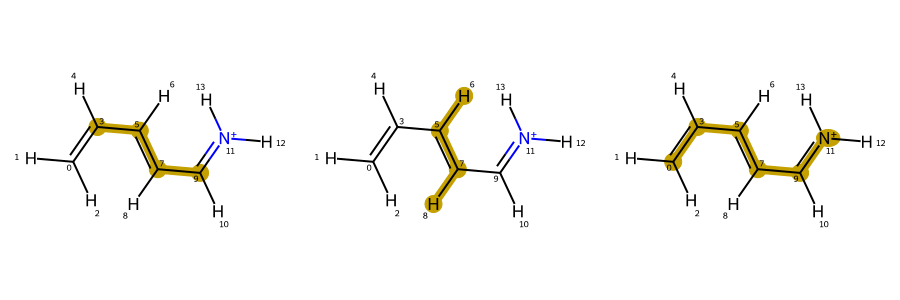

In [4]:
from shnitsel.geo.geomatch import flag_bats_multiple

smarts_phi1 = '[#6;D3]C=C[#6;D3]'
smarts_phi2 = '[#1][#6;D3;H1]=[#6;D3;H1][#1]'
smarts_bla = '[#6,#7]=[#6][#6]=[#6][#6]=[#6,#7]'

d_flag, img = flag_bats_multiple(mol, l_smarts=[smarts_phi1, smarts_phi2, smarts_bla], draw=True)
img

From the PCA plot, we can support that there are actually trajectories that isomerize:

INFO: Dimension atomcomb is being generated.
INFO: Dimension atomcomb is being generated.


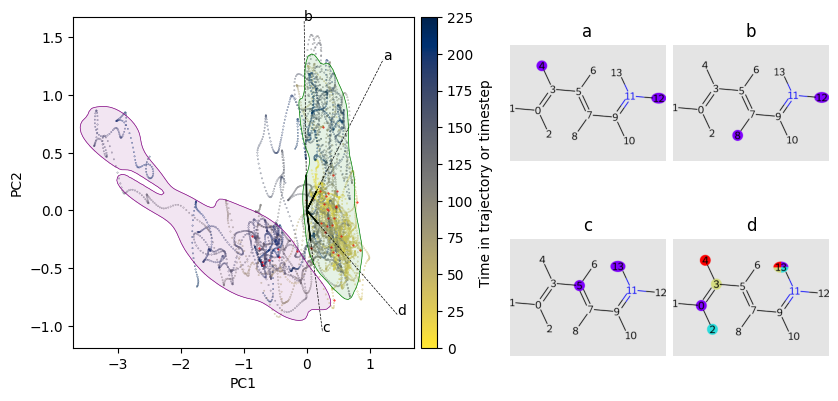

In [5]:
from shnitsel.vis.plot import biplot_kde

kde_data = biplot_kde(ds, 3,5,7,9)

## 2.2) Computing the Descriptors

After flagging the relevant internal coordinates, the corresponding geometric descriptors (bond lengths, bond angles, and torsion angles) are computed directly from the molecular geometries.

The values are obtained using the functions provided in `shnitsel.geo.geocalc`, with the previously generated flag dictionaries defining which internal coordinates are evaluated. This separation of coordinate selection and value computation enables a flexible and modular workflow.

In [6]:
import xarray as xr

# compute tagged torsion angles
kws = dict(ang='deg', signed=False)
phi1 = ds.atXYZ.st.get_bond_torsions(d_flag[smarts_phi1], **kws).squeeze('descriptor')
phi2 = ds.atXYZ.st.get_bond_torsions(d_flag[smarts_phi2], **kws).squeeze('descriptor')

# compute HOOP by subtracting phi2 from phi1 for every data point
arr_hoop = phi1.values - phi2.values

# compute BLA for tagged chromophor
bla = ds.atXYZ.st.get_bla_chromophor(d_flag[smarts_bla]).squeeze('descriptor')

# compute energy difference between S1 and S0
gap = ds.energy.sel(state=2) - ds.energy.sel(state=1)

with_hops = ds.st.assign_hop_time([(2, 1)])
to_plot = with_hops[['frame', 'hop_time', 'astate']].assign(
    dihedral=('frame', phi1.values, {'long_name': '$\phi_{CC=CC}$', 'units': '°'}),
    hoop=('frame', arr_hoop, {'long_name': 'HOOP', 'units': '°'}),
    bla=('frame', bla.values, {'long_name': 'BLA', 'units': bla.units}),
    gap=('frame', gap.values, {'long_name': '$\Delta E_{0,1}$', 'units': gap.units})
).assign_coords(
    time_at_hop=('trajid_', with_hops.time_at_hop.values)
).set_coords('astate')
to_plot

<xarray.Dataset> Size: 336kB
Dimensions:      (frame: 6452, trajid_: 16)
Coordinates:
  * frame        (frame) object 52kB MultiIndex
    hop_time     (frame) float64 52kB -113.0 -112.5 -112.0 ... 13.0 13.5 14.0
    astate       (frame) int32 26kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1
  * trajid       (frame) int64 52kB 1 1 1 1 1 1 1 1 ... 20 20 20 20 20 20 20 20
  * time         (frame) float64 52kB 0.0 0.5 1.0 1.5 ... 218.0 218.5 219.0
    time_at_hop  (trajid_) float64 128B 113.0 162.0 66.5 ... 100.5 149.0 205.0
Dimensions without coordinates: trajid_
Data variables:
    dihedral     (frame) float32 26kB 171.9 171.8 171.7 ... 89.29 88.93 88.52
    hoop         (frame) float32 26kB 1.129 2.127 2.995 ... 52.04 54.45 56.79
    bla          (frame) float32 26kB 0.11 0.1095 0.1068 ... 0.1536 0.1636
    gap          (frame) float32 26kB 0.172 0.1727 0.1735 ... 0.09016 0.09393
Attributes:
    delta_t:               0.5
    input_format_version:  3.0
    num_triplets:          0
    input_type:            dynamic
    num_doublets:          0
    num_singlets:          3
    mol:                   <rdkit.Chem.rdchem.Mol object at 0x7f7df006be20>

Using HoloViews (https://holoviews.org/), we can explore, e.g., how the HOOP coordinate evolves over time for each trajectory, with the trajectory colored continuously by the dihedral angle, to enable an intuitive extrapolative visualization.

In [7]:
uds = to_plot.st.unstack_trajs()
uds['trajid'].attrs['long_name'] = "Trajectory ID"
uds['dihedral'].attrs['long_name'] = "Dihedral"
uds

<xarray.Dataset> Size: 242kB
Dimensions:      (trajid: 16, time: 451)
Coordinates:
  * trajid       (trajid) int64 128B 1 2 3 4 6 7 8 9 10 12 13 14 17 18 19 20
  * time         (time) float64 4kB 0.0 0.5 1.0 1.5 ... 223.5 224.0 224.5 225.0
    hop_time     (trajid, time) float64 58kB -113.0 -112.5 -112.0 ... nan nan
    astate       (trajid, time) float64 58kB 2.0 2.0 2.0 2.0 ... nan nan nan nan
    is_frame     (trajid, time) bool 7kB True True True ... False False False
    time_at_hop  (trajid) float64 128B 113.0 162.0 66.5 ... 100.5 149.0 205.0
Data variables:
    dihedral     (trajid, time) float32 29kB 171.9 171.8 171.7 ... nan nan nan
    hoop         (trajid, time) float32 29kB 1.129 2.127 2.995 ... nan nan nan
    bla          (trajid, time) float32 29kB 0.11 0.1095 0.1068 ... nan nan nan
    gap          (trajid, time) float32 29kB 0.172 0.1727 0.1735 ... nan nan nan
Attributes:
    delta_t:               0.5
    input_format_version:  3.0
    num_triplets:          0
    input_type:            dynamic
    num_doublets:          0
    num_singlets:          3
    mol:                   <rdkit.Chem.rdchem.Mol object at 0x7f7df006be20>

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
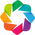

:HoloMap   [trajid]
   :Overlay
      .Curve.I   :Curve   [time]   (HOOP,Dihedral)
      .Scatter.I :Scatter   [time]   (HOOP,Dihedral)

In [8]:
import holoviews as hv
hv.extension('bokeh')

uds = to_plot.st.unstack_trajs()
uds['trajid'].attrs['long_name'] = "Trajectory ID"
uds['dihedral'].attrs['long_name'] = "Dihedral"
hvds = hv.Dataset(uds)
dims = dict(kdims='time', vdims=['hoop', 'dihedral'])
scatter_opts=dict(
    colorbar=True,
    size=10,
    frame_width=600,
    fontsize={'labels': 14, 'ticks': 14},
)
curve = hvds.to.curve(**dims)
scatter = hvds.to.scatter(**dims).opts(
    color='dihedral',
    clabel="Dihedral (°)",
    cmap='vanimo',
    **scatter_opts
)
hoop_dih = curve * scatter
hoop_dih

In [9]:
dims = dict(kdims='time', vdims=['dihedral', 'gap'])
curve2 = hvds.to.curve(**dims)
scatter2 = hvds.to.scatter(**dims).opts(
    color='gap',
    clabel=f"ΔE₀₁ ({uds.gap.units})",
    cmap='cividis',
    **scatter_opts
)
line = hv.HLine(90).opts(
    color='k', line_width=2, line_dash='dashed'
)
dih_gap = curve2 * scatter2 * line
dih_gap

:HoloMap   [trajid]
   :Overlay
      .Curve.I   :Curve   [time]   (Dihedral,$\Delta E_{0,1}$)
      .Scatter.I :Scatter   [time]   (Dihedral,$\Delta E_{0,1}$)
      .HLine.I   :HLine   [x,y]

In [10]:
# (hoop_dih + dih_gap).cols(1)

From the color-coding it is apparent, in which trajectories, isomerization occurs and that we can classify the trajectories based on the dihedral angle in the final frames, i.e. see that trajectories 1, 2, 12 and 14 reach a region with dihedral angles below 90° in a region of greater energy gap between $S_0$ and $S_1$ (yellow vs. region of hopping in blue).

Another variant for plotting is given below, where we plot the change of the S$_1$-$S_0$ energy gap, the BLA and HOOP descriptor over time (color coded by the central dihedral).
By comparing e.g. trajectory #1 and #9 it is apparent, that isomerization occurs only in trajectory #1.

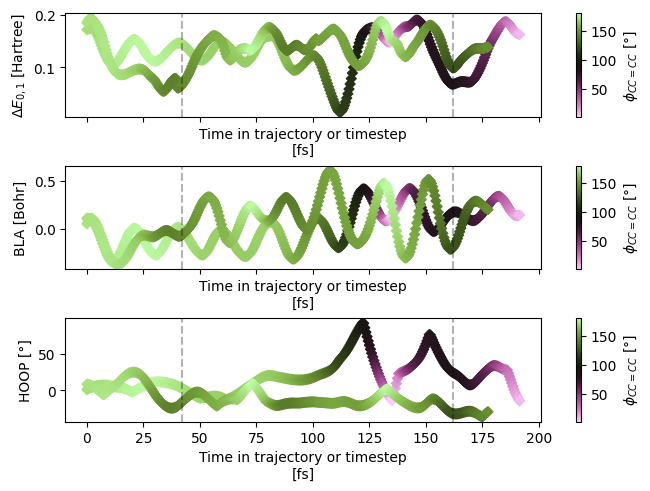

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, sharex=True, layout='constrained')

subset = to_plot.st.sel_trajs([1, 9])
for ax, v in zip(axes, ['gap', 'bla', 'hoop']):
    subset.plot.scatter(
        x='time', y=v, ax=ax, hue='dihedral', cmap='vanimo', marker='D', s=25, edgecolor='face')
    bottom, top = ax.get_ylim()
    # ax.vlines(subset.time_at_hop, bottom, top)
    for t in subset.time_at_hop:
        ax.axvline(t, color="black", linestyle="--", alpha=0.3)

In [14]:
ds.st.sel_trajs([1,9]).st.hops().time

<xarray.DataArray 'time' (frame: 2)> Size: 16B
[2 values with dtype=float64]
Coordinates:
  * frame     (frame) object 16B MultiIndex
  * trajid    (frame) int64 16B 1 9
  * time      (frame) float64 16B 113.0 40.0
    tidx      (frame) int64 16B 226 80
    hop_from  (frame) int32 8B 2 2
    hop_to    (frame) int32 8B 1 1
Attributes:
    long_name:   Time in trajectory or timestep
    unitdim:     time
    units:       fs
    __assigned:  True

In [16]:
subset[{'frame': subset.hop_time==0}]

<xarray.Dataset> Size: 120B
Dimensions:      (frame: 2, trajid_: 2)
Coordinates:
  * frame        (frame) object 16B MultiIndex
    hop_time     (frame) float64 16B 0.0 0.0
    astate       (frame) int32 8B 1 1
  * trajid       (frame) int64 16B 1 9
  * time         (frame) float64 16B 113.0 40.0
    time_at_hop  (trajid_) float64 16B 162.0 42.0
Dimensions without coordinates: trajid_
Data variables:
    dihedral     (frame) float32 8B 117.1 142.3
    hoop         (frame) float32 8B 46.72 -21.85
    bla          (frame) float32 8B -0.1716 -0.0754
    gap          (frame) float32 8B 0.01869 0.06129
Attributes:
    delta_t:               0.5
    input_format_version:  3.0
    num_triplets:          0
    input_type:            dynamic
    num_doublets:          0
    num_singlets:          3
    mol:                   <rdkit.Chem.rdchem.Mol object at 0x7f7df006be20>

To pin this finding into a structural reason, we align the trajectories to the time of the last $S_1\rightarrow{}S_0$ hop.
From this visualization it is clearly apparent, that the difference in reaction outcome can be associated with the HOOP motion, which goes towards negative values in case of no isomerization but positive values for the isomerizing case (trajectory #1).

Now we can inspect the pairwise correlations between the key properties at the last $S_1 \rightarrow S_0$ hopping point to evaluate whether our conclusions hold across the dataset.

To do this, we first assign labels to each trajectory based on its final dihedral angle, indicating whether it underwent isomerization. We then extract the data corresponding to the hopping points and plot the pairwise relationships using a pairplot. From this visualization, it becomes clear that in most trajectories where no isomerization occurs, the HOOP angle remains near zero, while the central torsion angle stays between 100° and 180°.

In [25]:
import xarray as xr
max_Z = 70
min_E = 110

# last S1 -> S0 hop of each trajectory:
hops_isom = to_plot[['dihedral', 'bla', 'hoop', 'gap', 'astate']].st.hops([(2, 1)]).groupby('trajid').last()
# last dihedral value of each trajectory:
ld = to_plot['dihedral'].groupby('trajid').last()
hops_isom['isomerization'] = xr.where(
    ld < max_Z, "E-to-Z", xr.where(ld > min_E, "E-to-E", "undetermined"))

In [26]:
df_hops_plot = hops_isom.to_dataframe()
df_hops_plot

,dihedral,bla,hoop,gap,isomerization
trajid,,,,,
1,117.072639,-0.171581,46.720375,0.018692,E-to-Z
2,82.179283,0.051443,2.145355,0.006378,E-to-Z
3,129.283890,0.057555,72.827255,0.008133,E-to-E
6,167.267899,0.057904,15.829803,0.015869,E-to-E
8,95.843857,-0.104081,3.553558,0.001389,E-to-E
9,142.292664,-0.075405,-21.852066,0.061295,E-to-E
10,164.423599,-0.102757,15.222458,0.005295,E-to-E
12,132.085754,-0.062993,72.474442,0.037140,E-to-Z
14,63.639641,-0.101652,-20.741882,0.034119,E-to-Z


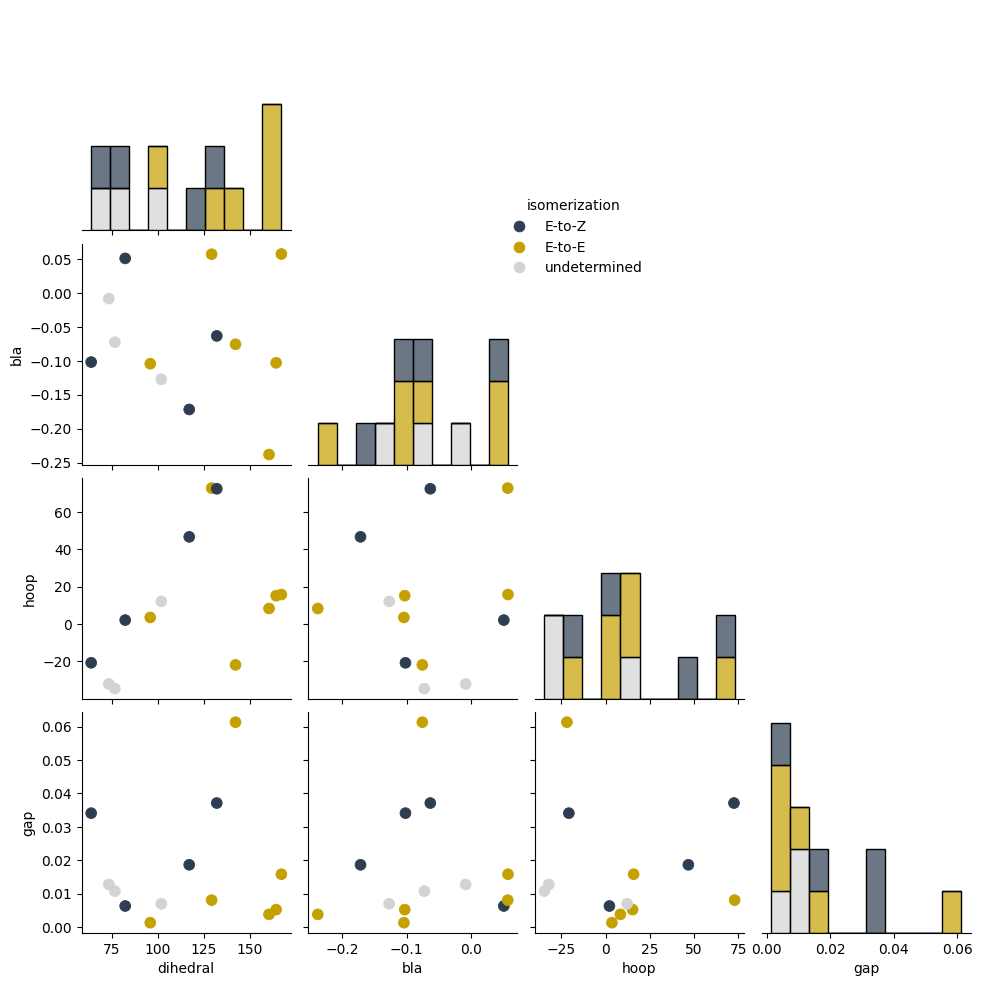

In [27]:
import seaborn as sns

# pairplot
st_blue = (44/255, 62/255, 80/255)
st_yellow = (196/255, 160/255, 0/255)

g = sns.pairplot(
    df_hops_plot,
    vars=["dihedral", "bla", "hoop", "gap"],
    hue="isomerization",
    palette={"E-to-Z": st_blue, "E-to-E": st_yellow, 'undetermined': 'lightgray'},
    diag_kind='hist', diag_kws={'multiple':'stack', 'alpha':0.7, 'bins':10},
    plot_kws={"s": 60, "edgecolor": None, "alpha": 1},
    corner=True,
)

g._legend.set_bbox_to_anchor((0.5, 0.8))
g._legend.set_loc('upper center')

## Alternative to the plot_stack replacement approach shown above

It is possible that matplotlib will no longer work for non-holoviews plotting after this cell is run, and until the notebook is restarted.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Layout
   .Overlay.I   :Overlay
      .Scatter.I  :Scatter   [time]   ($\Delta E_{0,1}$,Dihedral)
      .Scatter.II :Scatter   [time]   ($\Delta E_{0,1}$,Dihedral)
   .Overlay.II  :Overlay
      .Scatter.I  :Scatter   [time]   (BLA,Dihedral)
      .Scatter.II :Scatter   [time]   (BLA,Dihedral)
   .Overlay.III :Overlay
      .Scatter.I  :Scatter   [time]   (HOOP,Dihedral)
      .Scatter.II :Scatter   [time]   (HOOP,Dihedral)
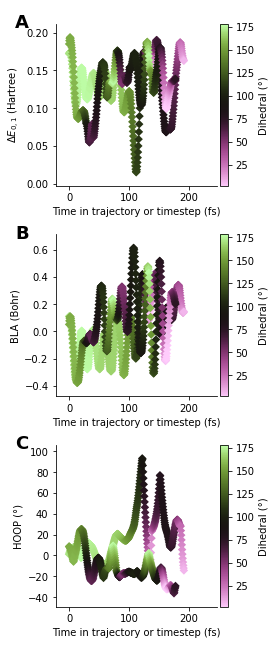

In [28]:
hv.extension('matplotlib')
hvds = hv.Dataset(uds.reset_coords(['time_at_hop']))
selected_trajs = [1, 9]
plots = [
    hv.Overlay(
        [
            hvds.sample(trajid=i).to.scatter(kdims='time', vdims=[x, 'dihedral'])
            for i in selected_trajs
        ]
        #   + [
        #     hvds.sample(trajid=i).to(hv.VLines, kdims='time_at_hop')
        #     for i in selected_trajs
        # ]
    )
    for x in ['gap', 'bla', 'hoop']
]
lo = hv.Layout(plots).cols(1)
lo.opts(hv.opts.Scatter(color='dihedral', cmap='vanimo', marker='D', colorbar=True))

## Alternative to the Seaborn pairplot
Colours still need adjusting

In [29]:
# TODO: remove: hvplot is not worth it.
import hvplot.xarray
# hops_isom.to_array('variable').hvplot.scatter_matrix()
# hvplot.plotting.scatter_matrix(hops_isom.to_dataarray('variable', name='value'), x='' c='isomerization')
hvplot.plotting.scatter_matrix(df_hops_plot[['bla', 'hoop', 'dihedral', 'gap', 'isomerization']], c='isomerization')

:GridMatrix   [X,Y]
   :NdOverlay   [isomerization]
      :Histogram   [hoop]   (Count)